## 神经网络简介  


In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [21]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    #创建一个新的目标特征，即median_house_value_is_high
    #通过median_house_value是否大于265000来判断
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [22]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2642.2,538.1,1424.7,500.1,3.9,2.0
std,2.2,2.0,12.6,2229.0,426.8,1137.2,389.3,1.9,1.2
min,32.5,-124.3,1.0,11.0,3.0,3.0,3.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,295.0,786.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2125.0,432.0,1161.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3135.2,646.0,1705.2,600.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2647.3,542.5,1441.2,503.8,3.9,2.0
std,2.1,2.0,12.6,2057.7,408.5,1173.2,372.9,1.9,1.1
min,32.5,-124.3,2.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,302.8,794.0,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2141.0,439.0,1181.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3193.0,654.0,1753.2,616.0,4.7,2.3
max,41.8,-114.6,52.0,25135.0,4952.0,35682.0,4769.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,207.5
std,116.8
min,15.0
25%,118.8
50%,179.7
75%,265.6
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.8
std,114.1
min,15.0
25%,121.3
50%,181.8
75%,262.8
max,500.0


## 构建神经网络  
神经网络由`DNNRegressor`类定义，使用`hidden_units` 定义神经网络结构，该参数会创建一个整数列表，其中每个整数对应一个隐藏层，表示其中的节点数。  
例如：`hidden_units=[3,10]`  
表示为神经网络指定了两个隐藏层：  
* 第一个隐藏层包含3个节点。
* 第二个隐藏层包含10个节点。  
默认情况下，所以隐藏层都会使用ReLu激活函数，且是全连接层。

In [23]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

In [24]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """构建输入函数
    """
    
    # Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [25]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units
    )
  
  # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
        )
    # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor

### 训练神经网络模型  
调整超参数，将RMSE降到110以下  


Training model...
RMSE (on training data):
  period 00 : 103.75
  period 01 : 102.06
  period 02 : 99.68
  period 03 : 100.21
  period 04 : 98.79
  period 05 : 97.47
  period 06 : 96.83
  period 07 : 98.39
  period 08 : 95.81
  period 09 : 96.09
Model training finished.
Final RMSE (on training data):   96.09
Final RMSE (on validation data): 95.35


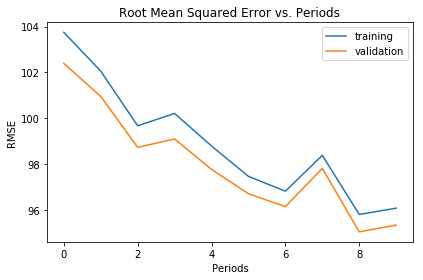

In [26]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.2,
    steps=1000,
    batch_size=100,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 133.77
  period 01 : 114.65
  period 02 : 108.77
  period 03 : 113.98
  period 04 : 103.29
  period 05 : 101.35
  period 06 : 101.05
  period 07 : 98.73
  period 08 : 97.78
  period 09 : 96.64
Model training finished.
Final RMSE (on training data):   96.64
Final RMSE (on validation data): 96.16


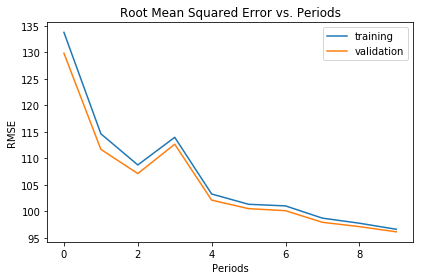

In [27]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.1,
    steps=1000,
    batch_size=100,
    hidden_units=[10, 2, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 109.04
  period 01 : 104.90
  period 02 : 96.12
  period 03 : 94.60
  period 04 : 93.29
  period 05 : 91.86
  period 06 : 90.26
  period 07 : 88.96
  period 08 : 88.57
  period 09 : 88.02
Model training finished.
Final RMSE (on training data):   88.02
Final RMSE (on validation data): 87.70


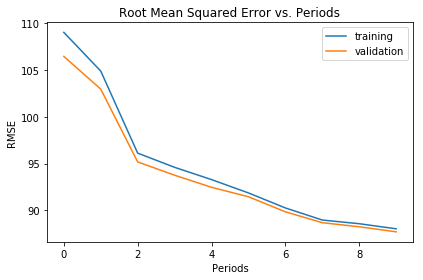

In [31]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 107.41
  period 01 : 101.17
  period 02 : 98.42
  period 03 : 97.00
  period 04 : 96.29
  period 05 : 95.84
  period 06 : 94.46
  period 07 : 93.65
  period 08 : 94.43
  period 09 : 92.94
Model training finished.
Final RMSE (on training data):   92.94
Final RMSE (on validation data): 93.91


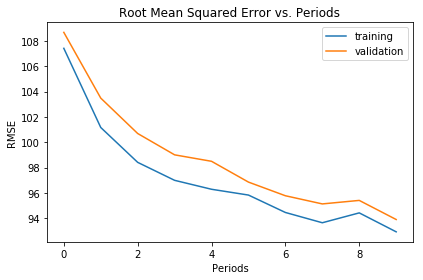

In [29]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 使用测试数据进行评估  


In [32]:
california_housing_test_data = pd.read_csv("california_housing_test.csv", sep=",")

# YOUR CODE HERE
testing_examples = preprocess_features(california_housing_test_data)
testing_targets = preprocess_targets(california_housing_test_data)
predict_testing_input_fn = lambda: my_input_fn(testing_examples,
                                              testing_targets["median_house_value"],
                                              num_epochs=1, 
                                              shuffle=False)
testing_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item['predictions'][0] for item in testing_predictions])
root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(testing_predictions, testing_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)



Final RMSE (on test data): 87.98
